# AutoregressiveModel

**Description:** AutoregressiveModel implemented in Keras to generate image.

**Objective:** The objective of this assignment is to practise using the TensorFlow machine learning framework
through implementing custom training modules and data reader modules for image generation on
the Chinese Calligraphy dataset using a convolutional neural network (CNN) based architecture.
Throughout the assignment, students will be guided to develop the CNN-based model step by
step and study how to build custom modules on TensorFlow and the effects of different model
configurations.

## Introduction

Image generation is one of the fundamental computer vision tasks, referring to the process of generating new images that are visually realistic and similar to real-world images. It is widely used in many applications, such as super resolution, photograph editing and 3D modelling. 

One approach to image generation is to use models that learn to predict the probability distribution of pixel values, given the values of all the previous pixels. These models generate images one pixel at a time, using the previously generated pixels to condition the generation of the next pixel.

### Setting environment

Note: You can only use the packages listed below !!!

In [83]:
import numpy as np
import math
import os
from PIL import Image


import time
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


## Getting the data


### Download dataset



In [84]:

# Download dataset from google drive
! wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=18ogOIVtYFkcCyNN6AHLCrTI95zMrYAZt' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=18ogOIVtYFkcCyNN6AHLCrTI95zMrYAZt" -O calligraphy.zip && rm -rf /tmp/cookies.txt
! mkdir ./data && unzip -q calligraphy.zip -d ./data/ && rm calligraphy.zip
! wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1w7JVXz6U-NVDZxBf1oSAVjKdR4BJs1zI' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1w7JVXz6U-NVDZxBf1oSAVjKdR4BJs1zI" -O calligraphy.zip && rm -rf /tmp/cookies.txt
! unzip -q calligraphy.zip -d ./data/ && rm calligraphy.zip
! ls -l ./data

--2023-04-02 06:46:46--  https://docs.google.com/uc?export=download&confirm=t&id=18ogOIVtYFkcCyNN6AHLCrTI95zMrYAZt
Resolving docs.google.com (docs.google.com)... 108.177.119.113, 108.177.119.139, 108.177.119.138, ...
Connecting to docs.google.com (docs.google.com)|108.177.119.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-9k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7r153k18sl57373ts7ebsskic59h3lug/1680417975000/03446042882167617448/*/18ogOIVtYFkcCyNN6AHLCrTI95zMrYAZt?e=download&uuid=bd89651e-3a83-43f4-a98a-b3b1576b21da [following]
--2023-04-02 06:46:47--  https://doc-08-9k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7r153k18sl57373ts7ebsskic59h3lug/1680417975000/03446042882167617448/*/18ogOIVtYFkcCyNN6AHLCrTI95zMrYAZt?e=download&uuid=bd89651e-3a83-43f4-a98a-b3b1576b21da
Resolving doc-08-9k-docs.googleusercontent.com (doc-08-9k-docs.googleusercontent.com)... 108.177.127.

### make dataset

In [85]:
# Model / data parameters
input_shape = (32, 32, 1)
batch_size = 32
train_data_dir = "./data/train_half"
test_data_dir = "./data/test_half"
data_name = "calligraphy"

In [86]:
# dataset class
class CalligraphySequence(tf.keras.utils.Sequence):

    def __init__(self, image_dir, batch_size, train, valid):
        ### [C1: Build init and len functions]
        # Your code here
        self.batch_size = batch_size
        self.image_dir = image_dir
        self.filename_list = os.listdir(self.image_dir)
        if train and valid:
          self.filename_list = self.filename_list[int(len(self.filename_list)*0.8):]
        elif train:
          self.filename_list = self.filename_list[:int(len(self.filename_list) * 0.8)]
    def __len__(self):
        ### [C1: Build init and len functions]
        # Your code here
        return math.ceil(len(self.filename_list) / self.batch_size)

    def __getitem__(self, idx):
        ### [C2: Build getitem function]
        # Round all pixel values less than 33% of the max 256 value to 0
        # anything above this value gets rounded up to 1 so that all values are either
        # 0 or 1
        # Your code here
        filename_batch = self.filename_list[idx * self.batch_size:
                          (idx + 1) * self.batch_size]

        image_list = []

        for filename in filename_batch:

          img = Image.open(os.path.join(self.image_dir,filename))
          
          #1,2 Conver the image to grayscale and resize the image
          img = img.convert('L').resize((32,32))
          
          #3 Normalize the image
          img = np.array(img) / 255.0
          
          #4 Binarize the image
          img[img>=0.33] = 1
          img[img<0.33] = 0


          img = img.reshape((32,32,1))
          # print(img.shape)
          # display(PIL.Image.fromarray(np.uint8(img*255)))
          # break
          image_list.append(img)

        image_list = np.array(image_list)
        return image_list, image_list

    def show(self, idx):
      img = Image.open(os.path.join(self.image_dir, self.filename_list[idx]))
      display(img)


# final shape should be 1313 (32, 32, 32, 1) (32, 32, 32, 1)
train_ds = CalligraphySequence(train_data_dir, batch_size, train=True, valid= False)
valid_ds = CalligraphySequence(train_data_dir, batch_size, train=True, valid= True)
test_ds = CalligraphySequence(test_data_dir, batch_size, train=False, valid = False)

print(len(train_ds), train_ds[0][0].shape, train_ds[0][1].shape)

print(len(valid_ds), valid_ds[0][0].shape, valid_ds[0][1].shape)

print(len(test_ds), test_ds[0][0].shape, test_ds[0][1].shape)
# for i in train_ds[0][0]:
#     print(i.shape)
#     display(PIL.Image.fromarray(np.uint8(i*255)))




1050 (32, 32, 32, 1) (32, 32, 32, 1)
263 (32, 32, 32, 1) (32, 32, 32, 1)
329 (32, 32, 32, 1) (32, 32, 32, 1)


## Create layers for the requisite Layers for the model


### Given function for conv2d / down_shift / right_shift / concat_elu
1. conv2d: 2d convolution layer using layers.Conv2D

2. down_shift: shift feature down in height dimension (by padding zero to the top and drop the bottom)

3. right_shift: shift feature right in width dimension

4. concat_elu: a nonlinearity layer (http://arxiv.org/abs/1603.05201)

The down_shift and right_shift functions are used to avoid information leaks in a causal network.


In [87]:
class Conv2d(layers.Layer):
    def __init__(self, num_filters, filter_size=[3, 3], stride=[1, 1], pad='SAME', nonlinearity=None, **kwargs):
        super().__init__()
        self.conv = layers.Conv2D(num_filters, filter_size, padding = pad, strides = stride, activation = nonlinearity, 
                         kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05))

    def call(self, x):
        return self.conv(x)

def down_move(x, step=1):
    input_shape = tf.shape(x)
    return tf.concat([tf.zeros((input_shape[0], step, input_shape[2], input_shape[3])), x[:, :input_shape[1] - step, :, :]], 1)

def right_move(x, step=1):
    input_shape = tf.shape(x)
    return tf.concat([tf.zeros((input_shape[0], input_shape[1], step, input_shape[3])), x[:, :, :input_shape[2] - step, :]], 2)

def concat_elu(x):
    """ like concatenated ReLU (http://arxiv.org/abs/1603.05201), but then with ELU """
    axis = len(x.get_shape()) - 1
    out = tf.nn.elu(tf.concat([x, -x], axis))
    return out

### Gated Residual Block
The GatedResnet class applies gated residual connections to input tensors for feature extraction.

Please follow Section 4.2.3 to implement coding question.


In [88]:
class DownMovedConv2d(layers.Layer):
    def __init__(self, num_filters, filter_size=[2, 3], stride=[1, 1], pad='VALID', nonlinearity=None, **kwargs):
        super().__init__()
        ### [C4: Build DownMovedConv2d.]
        # Your code here
        self.conv = layers.Conv2D(num_filters, filter_size, padding = pad, strides = stride, activation = nonlinearity, 
                  kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05))
        self.filter_size = filter_size

    def call(self, x):
        ### [C4: Build DownMovedConv2d.]
        # Your code here
        # print('before DMC: ' + str(x.shape))
        paddings = tf.constant([[0,0], [self.filter_size[0]-1,0], [int((self.filter_size[1]-1)/2),int((self.filter_size[1]-1)/2)],[0,0]])
        x = tf.pad(x, paddings, "CONSTANT")
        # print('after DMC: ' + str(x.shape))
        return self.conv(x)

class DownRightMovedConv2d(layers.Layer):
    def __init__(self, num_filters, filter_size=[2, 2], stride=[1, 1], pad='VALID', nonlinearity=None, **kwargs):
        super().__init__()
        ### [C3: Build DownRightMovedConv2d.]
        # Your code here
        self.conv = layers.Conv2D(num_filters, filter_size, padding = pad, strides = stride, activation = nonlinearity, 
                  kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05))
        self.filter_size = filter_size
        

    def call(self, x):
        ### [C3: Build DownRightMovedConv2d.]
        # Your code here
        # print('before DRMC: ' + str(x.shape))
        paddings = tf.constant([[0,0],[self.filter_size[0]-1,0],[self.filter_size[1]-1,0],[0,0]])
        x = tf.pad(x, paddings, "CONSTANT")
        # print('after DRMC: ' + str(x.shape))        
        return self.conv(x)


class TensorDense(layers.Layer):
    def __init__(self, num_units, nonlinearity=None, **kwargs):
        super().__init__()
        ### [C5: Build TensorDense.]
        # Your code here
        self.dense = layers.Dense(units = num_units, activation = nonlinearity,
                                  kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05))
        self.num_units = num_units 

    def call(self, x):
        ### [C5: Build TensorDense.]
        # Your code here
        # print('output shape before TensorDense' + str(x.shape))
        e = tf.shape(x)
        
        B = e[0]
        H = e[1]
        W = e[2]
        C = e[3]
        # print("B: " + str(B))
        # if B is None:
        #   shape = (H*W, C)
        # else:
        shape = (B*H*W,C)
        x = tf.reshape(x, shape)
        new_x = self.dense(x)
        # print('output shape after TensorDense' + str(new_x.shape))
        
        return tf.reshape(new_x, (B,H,W,self.num_units))
        
        
        

class GatedResnet(layers.Layer):
    def __init__(self, num_filters, nonlinearity=concat_elu, **kwargs):
        super().__init__()
        ### [C6: Build GatedResnet.]
        # Your code here
        self.nnLayer_1 = DownRightMovedConv2d(num_filters = num_filters)
        self.nnLayer_2 = DownRightMovedConv2d(num_filters = (num_filters * 2))
        self.nonlinearity = nonlinearity

    def call(self, x):
        ### [C6: Build GatedResnet.]
        # print('x shape: ' + str(x.shape))

        # Your code here
        x_1 = self.nonlinearity(x)
        # print('nonlinearity shape: ' + str(x_1.shape))

        x_1 = self.nnLayer_1(x_1)
        # print('nnLayer_1 shape: ' + str(x_1.shape))
        
        x_2 = self.nonlinearity(x_1)
        # print('nonlinearity shape: ' + str(x_2.shape))

        x_2 = self.nnLayer_2(x_2)
        # print('nnLayer_2 shape: ' + str(x_2.shape))

        F, G = tf.split(x_2, num_or_size_splits=2, axis = 3)
        

        

        G = tf.nn.sigmoid(G)
        
        # print('F:' + str(F.shape))
        # print('G: ' + str(G.shape))
        T = tf.multiply(F,G)
        # print('T: ' + str(T.shape))
        output = tf.add(T, x)

        # print('output shape after gatedresnet: ' + str(output.shape))

        return output

### Main AutoregressiveModel

In [89]:
class AutoregressiveModel(layers.Layer):
    def __init__(self, n_resnet=5, n_filters=256, n_block=12, n_output=10, **kwargs):
        super().__init__()
        self.n_resnet = n_resnet
        self.n_filters = n_filters
        self.n_block = n_block
        self.n_output = n_output
        # init all network layers
        self.down_moved_conv2d = DownMovedConv2d(num_filters=self.n_filters, filter_size=[1, 3])
        self.down_right_moved_conv2d = DownRightMovedConv2d(num_filters=self.n_filters, filter_size=[2, 1])
        ### [C7: Build AutoregressiveModel.]
        # Your code here
        self.out_dense = TensorDense(num_units = self.n_output, activation = tf.nn.elu)
        self.ul_list_gated_resnet = [GatedResnet(num_filters = self.n_filters) for _ in range(self.n_resnet * self.n_block)]
        self.ul_list_dense_layer = [TensorDense(num_units = n_filters) for _ in range(self.n_block)]

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        x = down_move(self.down_moved_conv2d(inputs)) + right_move(self.down_right_moved_conv2d(inputs))
        ### [C7: Build AutoregressiveModel.]
        # Your code here
        k = 0
        for i in range(self.n_resnet * self.n_block):
          x = self.ul_list_gated_resnet[i](x)
          if (i+1) % self.n_resnet == 0:

            # print(str(k))
            x = self.ul_list_dense_layer[k](x)
            k += 1

        x = self.out_dense(tf.nn.elu(x))
        return x

## Build the model based on the original paper


In [94]:
## Build the model based on the original paper

inputs = keras.Input(shape=input_shape, dtype=tf.float32)
AM = AutoregressiveModel(n_resnet=6, n_filters=64, n_block=6, n_output=10)

x = AM(inputs)

out = keras.layers.Conv2D(
    
    filters=1, kernel_size=1, strides=1, activation="sigmoid", padding="valid"
)(x)

pixel_cnn = keras.Model(inputs, out)

### [C11: Model training and log reporting]
# you can use keras.optimizers.Adam here to define "adam"
# compile your model and make a summary on its architecture
# Your code here

pixel_cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001,
                                                     beta_1=0.95,
                                                     beta_2=0.9995,
                                                     epsilon=1e-6,
                                                     use_ema=True,
                                                     ema_momentum=0.9995), 
                                loss = tf.keras.losses.BinaryCrossentropy())
pixel_cnn.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 32, 32, 1)]       0         
                                                                 
 autoregressive_model_18 (Au  (None, 32, 32, 10)       3571914   
 toregressiveModel)                                              
                                                                 
 conv2d_1414 (Conv2D)        (None, 32, 32, 1)         11        
                                                                 
Total params: 3,571,925
Trainable params: 3,571,925
Non-trainable params: 0
_________________________________________________________________


In [59]:
pixel_cnn.fit(train_ds, batch_size = 32, epochs = 10)

Epoch 1/10
1313/1313 [==============================] - 563s 401ms/step - loss: 0.1873
Epoch 2/10
1313/1313 [==============================] - 527s 402ms/step - loss: 0.1830
Epoch 3/10
1313/1313 [==============================] - 527s 401ms/step - loss: 0.1822
Epoch 4/10
1313/1313 [==============================] - 527s 401ms/step - loss: 0.1815
Epoch 5/10
1313/1313 [==============================] - 527s 401ms/step - loss: 0.1807
Epoch 6/10
1313/1313 [==============================] - 527s 401ms/step - loss: 0.1801
Epoch 7/10
1313/1313 [==============================] - 527s 401ms/step - loss: 0.1794
Epoch 8/10
1313/1313 [==============================] - 526s 401ms/step - loss: 0.1787
Epoch 9/10
1313/1313 [==============================] - 527s 401ms/step - loss: 0.1781
Epoch 10/10
1313/1313 [==============================] - 526s 401ms/step - loss: 0.1774
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape     

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [96]:
### [C8: Load the pretrained weights]
# Your code here
pixel_cnn.evaluate(test_ds)
pixel_cnn.load_weights('./drive/MyDrive/comp4211_pa2_data/pixel_cnn_e5.h5')
pixel_cnn.evaluate(test_ds)

329/329 [==============================] - 43s 130ms/step - loss: 0.1848


0.18482431769371033

In [60]:
# save weights 
pixel_cnn.save_weights('pixel_cnn_e15.h5')

## Demonstration

The AutoregressiveModel cannot generate the full image at once. Instead, it must generate each pixel in
order, append the last generated pixel to the current image, and feed the image back into the
model to repeat the process.

  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 1/32 [00:03<01:38,  3.17s/it]

1/1 [==============================] - 0s 39ms/step


  6%|▋         | 2/32 [00:07<01:49,  3.66s/it]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 3/32 [00:10<01:38,  3.39s/it]

1/1 [==============================] - 0s 35ms/step


 12%|█▎        | 4/32 [00:13<01:32,  3.30s/it]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 5/32 [00:16<01:26,  3.21s/it]

1/1 [==============================] - 0s 45ms/step


 19%|█▉        | 6/32 [00:20<01:29,  3.45s/it]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 7/32 [00:23<01:25,  3.43s/it]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 8/32 [00:26<01:20,  3.34s/it]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 9/32 [00:30<01:15,  3.28s/it]

1/1 [==============================] - 0s 60ms/step


 31%|███▏      | 10/32 [00:33<01:16,  3.48s/it]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 11/32 [00:37<01:11,  3.42s/it]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 12/32 [00:40<01:06,  3.32s/it]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 13/32 [00:43<01:02,  3.27s/it]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 14/32 [00:49<01:14,  4.12s/it]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 15/32 [00:53<01:07,  3.98s/it]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 16/32 [00:56<01:01,  3.87s/it]

1/1 [==============================] - 0s 46ms/step


 53%|█████▎    | 17/32 [01:00<00:58,  3.89s/it]

1/1 [==============================] - 0s 91ms/step


 56%|█████▋    | 18/32 [01:04<00:55,  3.97s/it]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 19/32 [01:10<00:58,  4.47s/it]

1/1 [==============================] - 0s 95ms/step


 62%|██████▎   | 20/32 [01:14<00:53,  4.44s/it]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 21/32 [01:19<00:48,  4.43s/it]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 22/32 [01:23<00:42,  4.24s/it]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 23/32 [01:27<00:37,  4.19s/it]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 24/32 [01:31<00:34,  4.26s/it]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 25/32 [01:34<00:27,  3.86s/it]

1/1 [==============================] - 0s 25ms/step


 81%|████████▏ | 26/32 [01:37<00:21,  3.64s/it]

1/1 [==============================] - 0s 43ms/step


 84%|████████▍ | 27/32 [01:40<00:17,  3.49s/it]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 28/32 [01:45<00:15,  3.77s/it]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 29/32 [01:48<00:10,  3.58s/it]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 30/32 [01:51<00:06,  3.43s/it]

1/1 [==============================] - 0s 85ms/step


 97%|█████████▋| 31/32 [01:54<00:03,  3.43s/it]

1/1 [==============================] - 0s 26ms/step


100%|██████████| 32/32 [01:59<00:00,  3.74s/it]


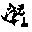

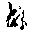

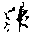

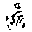

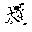

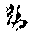

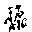

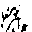

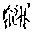

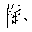

In [74]:
from IPython.display import Image, display

# Create an empty array of pixels.
batch = 10 # you may want to change this parameter 
pixels = np.zeros(shape=(batch,) + (pixel_cnn.input_shape)[1:])
batch, rows, cols, channels = pixels.shape
# Iterate over the pixels because generation has to be done sequentially pixel by pixel.
for row in tqdm(range(rows)):
    for col in range(cols):
        for channel in range(channels):
            ### [C9: Qualitative Evaluation]
            # Your code here
            # 1. Feed the whole array and retrieving the pixel value probabilities for the next
            # pixel. You can use model.predict function to get predict value for each pixel.
            h = pixel_cnn.predict(pixels)[:,row,col,channel]
            pixels[:,row,col,channel] = np.random.binomial(1, h)

            # h = pixel_cnn.predict(pixels)[:,row,col,channel]
            # pixels[:,row,col,channel] = h + tf.random.uniform(shape = [batch])
            # 2. Use the probabilities to pick pixel values and append the values to the image
            # frame. you can use tf.math.ceil to achieve the 0.5 threshold.
            
            # pixels[:,row,col,channel] = list(map(lambda b: 1 if b > 0.5 else 0, pixels[:,row,col,channel]))
            

def deprocess_image(x):
    # Stack the single channeled black and white image to RGB values.
    x = np.stack((x, x, x), 2)
    # Undo preprocessing
    x *= 255.0
    # Convert to uint8 and clip to the valid range [0, 255]
    x = np.clip(x, 0, 255).astype("uint8")
    return x


# Iterate over the generated images and plot them with matplotlib.
for i, pic in enumerate(pixels):
    keras.preprocessing.image.save_img(
        "generated_image_{}.png".format(i), deprocess_image(np.squeeze(pic, -1))
    )

display(Image("generated_image_0.png"))
display(Image("generated_image_1.png"))
display(Image("generated_image_2.png"))
display(Image("generated_image_3.png"))
display(Image("generated_image_4.png"))
display(Image("generated_image_5.png"))
display(Image("generated_image_6.png"))
display(Image("generated_image_7.png"))
display(Image("generated_image_8.png"))
display(Image("generated_image_9.png"))

## Quantitative Evaluation



In [97]:
pixel_cnn.evaluate(test_ds)

329/329 [==============================] - 43s 131ms/step - loss: 0.1848


0.18482431769371033